In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
tipo = "DelayVariavel/P0_100/"
base = "../../../../Simulations/SingleCell/" + tipo
graphicsbase = "../pdfs/" + tipo
until = 21
users = 51
scheds = 9
import sys
sys.path.append("..")
from LTEParser import LTEParser
parser = LTEParser()
files = parser.getFiles(base, graphicsbase, scheds, users, until)
metrics = {
    "VIDEO":{
        "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "VOICE":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "WEB":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "CBR":{
       "GPUTS": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "FAIR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "DELAY": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "JITTER": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []},
        "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    },
    "GERAL": {
      "PLR": {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7:[], 8: []}
    }
}
for sched in range(1, 9):
    for ue in range(10, users, 10):
        info = parser.parse(files[sched][ue], 100)
        #VIDEO
        metrics["VIDEO"]["GPUTS"][sched].append(info[0])
        metrics["VIDEO"]["FAIR"][sched].append(info[1])
        metrics["VIDEO"]["DELAY"][sched].append(info[2])
        metrics["VIDEO"]["JITTER"][sched].append(info[3])
        metrics["VIDEO"]["PLR"][sched].append(info[4])
        #VOICE
        metrics["VOICE"]["GPUTS"][sched].append(info[5])
        metrics["VOICE"]["FAIR"][sched].append(info[6])
        metrics["VOICE"]["DELAY"][sched].append(info[7])
        metrics["VOICE"]["JITTER"][sched].append(info[8])
        metrics["VOICE"]["PLR"][sched].append(info[9])
        #WEB
        metrics["WEB"]["GPUTS"][sched].append(info[10])
        metrics["WEB"]["FAIR"][sched].append(info[11])
        metrics["WEB"]["DELAY"][sched].append(info[12])
        metrics["WEB"]["JITTER"][sched].append(info[13])
        metrics["WEB"]["PLR"][sched].append(info[14])
        #CBR
        metrics["CBR"]["GPUTS"][sched].append(info[15])
        metrics["CBR"]["FAIR"][sched].append(info[16])
        metrics["CBR"]["DELAY"][sched].append(info[17])
        metrics["CBR"]["JITTER"][sched].append(info[18])
        metrics["CBR"]["PLR"][sched].append(info[19])
        #GERAL
        metrics["GERAL"]["PLR"][sched].append(info[20])
    #VIDEO
for app in metrics:
    for metric in metrics[app]:
        for sched in metrics[app][metric]:
            metrics[app][metric][sched] = np.array(metrics[app][metric][sched], dtype=np.float32)

Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_1.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_2.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_3.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_4.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_5.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_6.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_7.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_8.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_10_9.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCe

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_40_18.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_40_19.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_40_20.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_50_1.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_50_2.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_50_3.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_50_4.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_50_5.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_1_UE_50_6.gz
	Parsing ...Done
Opening file: ../../../../

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_30_15.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_30_16.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_30_17.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_30_18.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_30_19.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_30_20.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_40_1.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_40_2.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_2_UE_40_3.gz
	Parsing ...Done
Opening file: ../../../

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_12.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_13.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_14.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_15.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_16.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_17.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_18.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_19.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_3_UE_20_20.gz
	Parsing ...Done
Opening file: ../../

Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_9.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_10.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_11.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_12.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_13.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_14.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_15.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_16.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_10_17.gz
	Parsing ...Done
Opening file: ../../../../Simulations/

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_6.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_7.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_8.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_9.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_10.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_11.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_12.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_13.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_4_UE_50_14.gz
	Parsing ...Done
Opening file: ../../../.

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_3.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_4.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_5.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_6.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_7.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_8.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_9.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_10.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_5_UE_40_11.gz
	Parsing ...Done
Opening file: ../../../../S

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_20_20.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_30_1.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_30_2.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_30_3.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_30_4.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_30_5.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_30_6.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_30_7.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_6_UE_30_8.gz
	Parsing ...Done
Opening file: ../../../../Si

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_10_17.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_10_18.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_10_19.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_10_20.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_20_1.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_20_2.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_20_3.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_20_4.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_20_5.gz
	Parsing ...Done
Opening file: ../../../..

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_50_14.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_50_15.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_50_16.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_50_17.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_50_18.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_50_19.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_7_UE_50_20.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_10_1.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_10_2.gz
	Parsing ...Done
Opening file: ../../..

	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_11.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_12.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_13.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_14.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_15.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_16.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_17.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_18.gz
	Parsing ...Done
Opening file: ../../../../Simulations/SingleCell/DelayVariavel/P0_100/SCHED_8_UE_40_19.gz
	Parsing ...Done
Opening file: ../../

# WEB
## GPUT

In [3]:
MEGAWEB = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
for sched in metrics["WEB"]["GPUTS"]:
    MEGAWEB[sched] = np.true_divide(metrics["WEB"]["GPUTS"][sched], 1e+6)

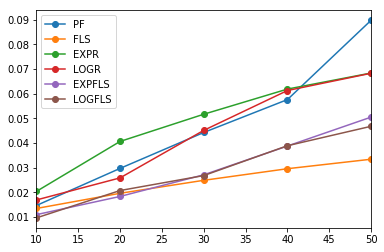

In [4]:
dfGPUTWEB = pd.DataFrame({'PF': MEGAWEB[1],
                       'FLS': MEGAWEB[4], 'EXPR': MEGAWEB[5], 'LOGR': MEGAWEB[6],
                        'EXPFLS': MEGAWEB[7], 'LOGFLS': MEGAWEB[8]},
                      index=[10,20,30,40,50])
plot = dfGPUTWEB.plot(rot=0, marker='o')
fig = plot.get_figure()
fig.savefig(graphicsbase + "GPUTWeb.pdf", bbox_inches='tight')

## Delay

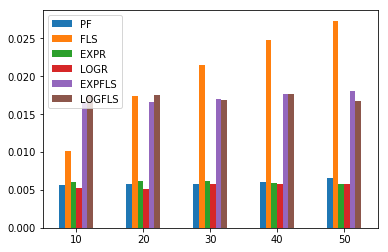

In [5]:
dfDELAYWEB = pd.DataFrame({'PF': metrics["WEB"]["DELAY"][1],
                            'FLS': metrics["WEB"]["DELAY"][4], 'EXPR': metrics["WEB"]["DELAY"][5], 'LOGR': metrics["WEB"]["DELAY"][6],
                             'EXPFLS': metrics["WEB"]["DELAY"][7], 'LOGFLS': metrics["WEB"]["DELAY"][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "DelayWeb.pdf", bbox_inches='tight')

## Jitter

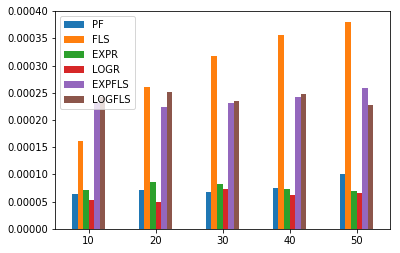

In [6]:
dfJITTERWEB = pd.DataFrame({'PF': metrics["WEB"]["JITTER"][1],
                            'FLS': metrics["WEB"]["JITTER"][4], 'EXPR': metrics["WEB"]["JITTER"][5], 'LOGR': metrics["WEB"]["JITTER"][6],
                            'EXPFLS': metrics["WEB"]["JITTER"][7], 'LOGFLS': metrics["WEB"]["JITTER"][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "JitterWebPF.pdf", bbox_inches='tight')

## FAIRNESS

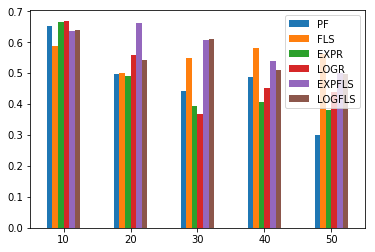

In [7]:
dfFAIRWEB = pd.DataFrame({'PF': metrics["WEB"]["FAIR"][1],
                            'FLS': metrics["WEB"]["FAIR"][4], 'EXPR': metrics["WEB"]["FAIR"][5], 'LOGR': metrics["WEB"]["FAIR"][6],
                            'EXPFLS': metrics["WEB"]["FAIR"][7], 'LOGFLS': metrics["WEB"]["FAIR"][8]},
                           index=[10,20,30,40,50])
plot = dfFAIRWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "FairnessWeb.pdf", bbox_inches='tight')

## PLR

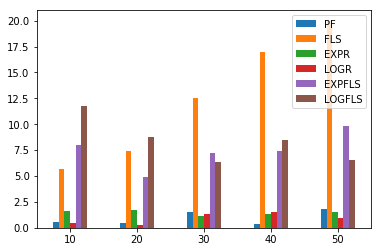

In [8]:
dfPLRWEB = pd.DataFrame({'PF': metrics["WEB"]["PLR"][1],
                            'FLS': metrics["WEB"]["PLR"][4], 'EXPR': metrics["WEB"]["PLR"][5], 'LOGR': metrics["WEB"]["PLR"][6],
                           'EXPFLS': metrics["WEB"]["PLR"][7], 'LOGFLS': metrics["WEB"]["PLR"][8]},
                           index=[10,20,30,40,50])
plot = dfPLRWEB.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "PacketLossWeb.pdf", bbox_inches='tight')

# CBR
## GPUT

In [9]:
MEGACBR = {1: [], 2: [], 3: [], 4: [], 5: [], 6: [], 7: [], 8: []}
for sched in metrics["CBR"]["GPUTS"]:
    MEGACBR[sched] = np.true_divide(metrics["CBR"]["GPUTS"][sched], 1e+6)

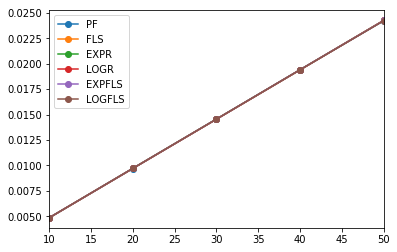

In [10]:
dfGPUTCBR = pd.DataFrame({'PF': MEGACBR[1],
                       'FLS': MEGACBR[4], 'EXPR': MEGACBR[5], 'LOGR': MEGACBR[6],
                        'EXPFLS': MEGACBR[7], 'LOGFLS': MEGACBR[8]},
                      index=[10,20,30,40,50])
plot = dfGPUTCBR.plot(rot=0, marker='o')
fig = plot.get_figure()
fig.savefig(graphicsbase + "GPUTCBR.pdf", bbox_inches='tight')

## Delay

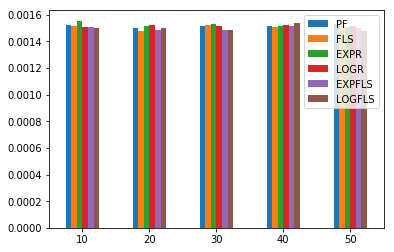

In [11]:
dfDELAYCBR = pd.DataFrame({'PF': metrics["CBR"]["DELAY"][1],
                            'FLS': metrics["CBR"]["DELAY"][4], 'EXPR': metrics["CBR"]["DELAY"][5], 'LOGR': metrics["CBR"]["DELAY"][6],
                             'EXPFLS': metrics["CBR"]["DELAY"][7], 'LOGFLS': metrics["CBR"]["DELAY"][8]},
                           index=[10,20,30,40,50])
plot = dfDELAYCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "DelayCBR.pdf", bbox_inches='tight')

## Jitter

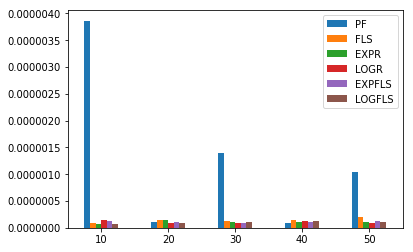

In [12]:
dfJITTERCBR = pd.DataFrame({'PF': metrics["CBR"]["JITTER"][1],
                            'FLS': metrics["CBR"]["JITTER"][4], 'EXPR': metrics["CBR"]["JITTER"][5], 'LOGR': metrics["CBR"]["JITTER"][6],
                            'EXPFLS': metrics["CBR"]["JITTER"][7], 'LOGFLS': metrics["CBR"]["JITTER"][8]},
                           index=[10,20,30,40,50])
plot = dfJITTERCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "JitterCBRPF.pdf", bbox_inches='tight')

## FAIRNESS

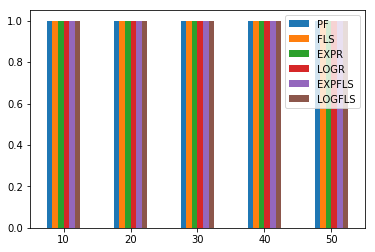

In [13]:
dfFAIRCBR = pd.DataFrame({'PF': metrics["CBR"]["FAIR"][1], 
                            'FLS': metrics["CBR"]["FAIR"][4], 'EXPR': metrics["CBR"]["FAIR"][5], 'LOGR': metrics["CBR"]["FAIR"][6],
                            'EXPFLS': metrics["CBR"]["FAIR"][7], 'LOGFLS': metrics["CBR"]["FAIR"][8]},
                           index=[10,20,30,40,50])
plot = dfFAIRCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "FairnessCBR.pdf", bbox_inches='tight')

## PLR

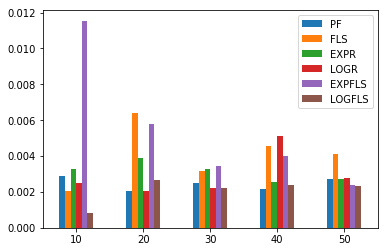

In [14]:
dfPLRCBR = pd.DataFrame({'PF': metrics["CBR"]["PLR"][1],
                            'FLS': metrics["CBR"]["PLR"][4], 'EXPR': metrics["CBR"]["PLR"][5], 'LOGR': metrics["CBR"]["PLR"][6],
                           'EXPFLS': metrics["CBR"]["PLR"][7], 'LOGFLS': metrics["CBR"]["PLR"][8]},
                           index=[10,20,30,40,50])
plot = dfPLRCBR.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "PacketLossCBR.pdf", bbox_inches='tight')

# Loss Ratio

In [15]:
averagePacketLoss = {}
for key in metrics["GERAL"]["PLR"]:
    averagePacketLoss[key] = []
    for i in range(0, 5):
        average = sum(metrics["GERAL"]["PLR"][key][i])/len(metrics["GERAL"]["PLR"][key][i])
        averagePacketLoss[key].append(average)

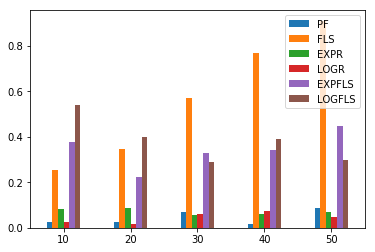

In [16]:
dfLossRatio = pd.DataFrame({'PF': averagePacketLoss[1],
                            'FLS': averagePacketLoss[4], 'EXPR': averagePacketLoss[5], 'LOGR': averagePacketLoss[6],
                           'EXPFLS': averagePacketLoss[7], 'LOGFLS': averagePacketLoss[8]},
                           index=[10,20,30,40,50])
plot = dfLossRatio.plot.bar(rot=0)
fig = plot.get_figure()
fig.savefig(graphicsbase + "PacketLossRatio.pdf", bbox_inches='tight')